In [1]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

In [2]:
import numpy as np

def get_data(num, w=2.0, b=3.0):
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 1)
        y = x * w + b + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

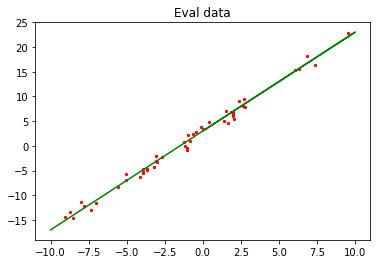

In [3]:
import matplotlib.pyplot as plt

eval_data = list(get_data(50))
x_target_label = np.array([-10, 10, 0.1])
y_target_label = x_target_label * 2 + 3
x_eval_label, y_eval_label = zip(*eval_data)

plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_target_label, y_target_label, color="green")
plt.title("Eval data")
plt.show()

In [4]:
from mindspore import dataset as ds

def create_dataset(num_data, batch_size=16, repeat_size=1):
    input_data = ds.GeneratorDataset(list(get_data(num_data)), column_names=['data', 'label'])
    input_data = input_data.batch(batch_size)
    input_data = input_data.repeat(repeat_size)
    return input_data


In [5]:
data_number = 1600
batch_number = 16
repeat_number = 1

ds_train = create_dataset(data_number, batch_size=batch_number, repeat_size=repeat_number)
print("The dataset size of ds_train:", ds_train.get_dataset_size())
dict_datasets = next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print("The x label value shape:", dict_datasets["data"].shape)
print("The y label value shape:", dict_datasets["label"].shape)


The dataset size of ds_train: 100
dict_keys(['data', 'label'])
The x label value shape: (16, 1)
The y label value shape: (16, 1)


In [6]:
from mindspore.common.initializer import Normal
from mindspore import nn
from mindspore.ops import TensorSummary

class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc = nn.Dense(1, 1, Normal(0.02), Normal(0.02))
        self.tensor_summary = TensorSummary()

    def construct(self, x):
        x = self.fc(x)
        self.tensor_summary("tensor", x)
        return x

In [7]:
net = LinearNet()
model_params = net.trainable_params()
for param in model_params:
    print(param, param.asnumpy())

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[-0.00971178]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [-0.01100923]


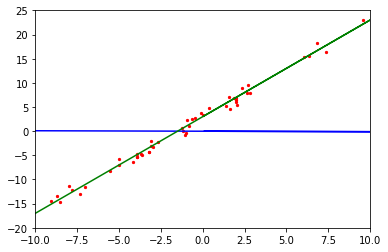

In [8]:
from mindspore import Tensor

x_model_label = np.array([-10, 10, 0.1])
y_model_label = (x_model_label * Tensor(model_params[0]).asnumpy()[0][0] +
                 Tensor(model_params[1]).asnumpy()[0])
plt.axis([-10, 10, -20, 25])
plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_model_label, y_model_label, color="blue")
plt.plot(x_target_label, y_target_label, color="green")
plt.show()

In [9]:
net = LinearNet()
net_loss = nn.loss.MSELoss()

In [10]:
opt = nn.Momentum(net.trainable_params(), learning_rate=0.005, momentum=0.9)

In [11]:
from mindspore import Model

model = Model(net, net_loss, opt)


In [12]:
import matplotlib.pyplot as plt
import time

def plot_model_and_datasets(net, eval_data):
    weight = net.trainable_params()[0]
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 0.1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*eval_data)
    x_target = x
    y_target = x_target * 2 + 3

    plt.axis([-11, 11, -20, 25])
    plt.scatter(x1, y1, color="red", s=5)
    plt.plot(x, y, color="blue")
    plt.plot(x_target, y_target, color="green")
    plt.show()
    time.sleep(0.2)


In [13]:
from IPython import display
from mindspore.train.callback import Callback

class ImageShowCallback(Callback):
    def __init__(self, net, eval_data):
        self.net = net
        self.eval_data = eval_data

    def step_end(self, run_context):
        plot_model_and_datasets(self.net, self.eval_data)
        display.clear_output(wait=True)

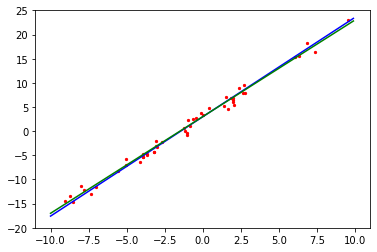

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[2.0563312]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [2.982458]


In [14]:
from mindspore.train.callback import SummaryCollector
from mindspore.profiler import Profiler
profiler = Profiler(output_path = './summary_dir/profiler_data')

epoch = 1
imageshow_cb = ImageShowCallback(net, eval_data)
summary_collector = SummaryCollector(summary_dir='./summary_dir', collect_freq=1)
model.train(epoch, ds_train, callbacks=[imageshow_cb, summary_collector], dataset_sink_mode=False)
profiler.analyse()
plot_model_and_datasets(net, eval_data)
for param in net.trainable_params():
    print(param, param.asnumpy())

In [15]:
!mindinsight start --summary-base-dir ./summary_dir

Reusing MindInsight on port 8080. (pid 37975, Use "mindinsight stop --port 8080" to stop it.) Web address: http://127.0.0.1:8080
